# **PyTorch - Transfer Learning com Formigas vs Abelhas**

---


1. Configurar nossos dados
2. Construindo o modelo para aprendizado por transferencia
3. Fine Tuning do modelo Convnet (resnet-18)
4. ConvNet como um extrator de caracteristicas

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Download our Dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip 

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### **Set our Data Transforms**

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Subtracts the mean from each value and then divides by the standard deviation.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # resizes the images so the shortest side has a length of 256 pixels. 
        # The other side is scaled to maintain the aspect ratio of the image.
        transforms.Resize(256), 
        # crops the center of the image so it is a 224 by 224 pixels square image.
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### **Criar nossos carregadores de dados** 
O comando **datasets.ImageFolder()** espera que nossos dados estejam organizados da seguinte maneira: `root/label/image.jpg`. Em outras palavras, as imagens devem ser classificadas em pastas. Por exemplo, todas as fotos de abelhas devem estar em uma pasta, todas as fotos de formigas devem estar em outra, assim:
- dataset_name/
  - /ants/
- dataset_name/
  - /bees/

In [4]:
# Set to your image path
data_dir = 'F:/hymenoptera_data/hymenoptera_data/'

# Use ImageFolder to point to our full dataset 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create our dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Get our dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


### **Visualize algumas imagens**


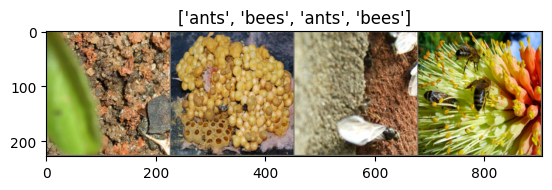

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### **Criar função para treinar o modelo**

Também usaremos os recursos nativos do PyTorch:

-  programador de taxa de aprendizagem
-  Checkpoint - salvar o melhor modelo

A seguir, o parâmetro ``scheduler`` é um objeto de temporizador de LR de
``torch.optim.lr_scheduler``.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### **Crie uma função para visualizar as previsões do nosso modelo**

In [7]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## **3. Fine Tuning da Convnet**
Carregamos um modelo **resnet18** pré-treinado e alteramos a camada final totalmente conectada para produzir o resultado do tamanho da nossa classe (2).

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\Gabriel\.conda\envs\dl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\.conda\envs\dl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Treinar e avaliar**

In [9]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5864 Acc: 0.6885
val Loss: 0.2336 Acc: 0.9020

Epoch 1/4
----------
train Loss: 0.5640 Acc: 0.7705
val Loss: 0.2443 Acc: 0.8954

Epoch 2/4
----------
train Loss: 0.4880 Acc: 0.8238
val Loss: 0.2681 Acc: 0.9150

Epoch 3/4
----------
train Loss: 0.5541 Acc: 0.7951
val Loss: 0.3386 Acc: 0.8627

Epoch 4/4
----------
train Loss: 0.4976 Acc: 0.7746
val Loss: 0.3789 Acc: 0.8366

Training complete in 0m 48s
Best val Acc: 0.915033


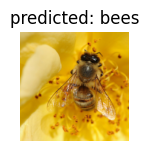

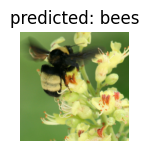

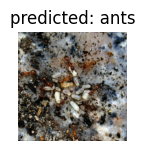

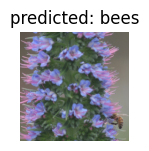

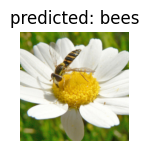

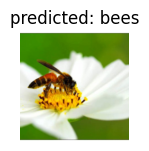

In [10]:
visualize_predictions(model_ft)

## **4. ConvNet como um extrator de características**
----------------------------------

Aqui, precisamos **congelar** todas as camadas de rede, exceto a camada final.

Precisamos definir ``requires_grad == False`` para congelar os parâmetros, de modo que os
gradientes não sejam calculados em ``backward()``.

You can read more about this in the documentation
here https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)

# We freeze layers here
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### **Treino e avaliação**

In [12]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6030 Acc: 0.6721
val Loss: 0.3574 Acc: 0.8235

Epoch 1/4
----------
train Loss: 0.5167 Acc: 0.7623
val Loss: 0.3260 Acc: 0.8758

Epoch 2/4
----------
train Loss: 0.5791 Acc: 0.7541
val Loss: 0.2498 Acc: 0.9346

Epoch 3/4
----------
train Loss: 0.4110 Acc: 0.8197
val Loss: 0.2071 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.3765 Acc: 0.8279
val Loss: 0.2000 Acc: 0.9281

Training complete in 0m 43s
Best val Acc: 0.947712


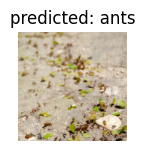

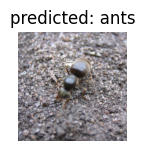

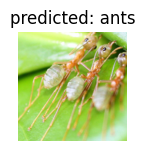

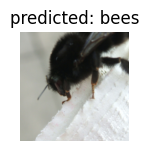

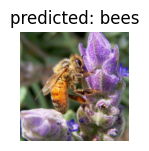

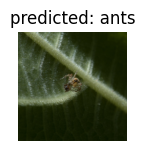

In [13]:
visualize_predictions(model_conv)